<a href="https://colab.research.google.com/github/aperrier004/video-analysis/blob/main/ImageClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projet du module Analyse de Vidéos

Ce projet consiste à détecter et suivre des objets sur des vidéos du dataset Grasp In The Wild. Il se décompose en trois parties distinctes :


1.   Entrainement d'un modèle de classification des objets à détecter
2.   Implémentation d'un tracker pour suivre l'objet à détecter dans une vidéo
3.   Amélioration du modèle avec une approche incremental learning

*Ce projet a été réalisé par Alban Perrier et Erwan Cado, encadrés par Boris Mansencal, responsable du module Analyse de Vidéos.*



## Entrainement du modèle de classification

Pour le modèle de classification, nous avons choisi d'entrainer uniquement les couches de classification d'un modèle MobileNetV2 pré-entraîné. Ce modèle a été entrainé sur des images d'objets extraites des vidéos du dataset GITW_Light.

In [ ]:
# On accède au répertoire du projet

%cd drive/MyDrive/3A/Analyse_de_vidéos/GITW_Light/

/content/drive/MyDrive/3A/Analyse_de_vidéos/GITW_Light


In [ ]:
# Import de tensorflow et keras

from tensorflow import keras
import tensorflow as tf
import datetime

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = (227,227)

### Récupération des données et chargement du modèle


In [ ]:
train_dataset = keras.utils.image_dataset_from_directory("DB/train", image_size=IMAGE_SIZE, batch_size=BATCH_SIZE)
test_dataset = keras.utils.image_dataset_from_directory("DB/test", shuffle=False, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE)
base_model = keras.models.load_model("models/mobilenet_based__16.h5")

base_model.summary()

Found 4736 files belonging to 5 classes.
Found 3568 files belonging to 5 classes.
Model: "functional_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 conv1_pad (ZeroPadding2D)   (None, 228, 228, 3)       0         
                                                                 
 conv1 (Conv2D)              (None, 113, 113, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 113, 113, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 113, 113, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 1

On optimise la lecture des données pour permettre un entraînement plus rapide.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Création du nouveau modèle

On applique le preprocessing utilisé lors de l'entraînement du modèle MobileNetV2. Ensuite, on ajoute des couches de classification au modèle de base et on compile le nouveau modèle.

In [ ]:
preprocess_input = keras.applications.mobilenet_v2.preprocess_input
IMG_SHAPE = IMAGE_SIZE + (3,)
base_model.trainable = False

In [ ]:
inputs = keras.Input(shape=IMG_SHAPE)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(512, activation='relu')(x)
outputs = keras.layers.Dense(5, activation='softmax')(x)
model = keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 227, 227, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 227, 227, 3)      0         
 a)                                                              
                                                                 
 functional_1 (Functional)   (None, 5)                 28922053  
                                                                 
 flatten (Flatten)           (None, 5)                 0         
                                                                 
 dense (Dense)               (None, 512)               3072  

### Entraînement du modèle

In [ ]:
initial_epochs = 10

history = model.fit(train_dataset,
                    epochs=initial_epochs)

Epoch 1/10
148/148 [==============================] - 457s 3s/step - loss: 1.4397 - accuracy: 0.8254
Epoch 2/10
148/148 [==============================] - 183s 1s/step - loss: 1.0474 - accuracy: 0.9994
Epoch 3/10
148/148 [==============================] - 183s 1s/step - loss: 0.6763 - accuracy: 0.9994
Epoch 4/10
148/148 [==============================] - 184s 1s/step - loss: 0.3927 - accuracy: 0.9994
Epoch 5/10
148/148 [==============================] - 182s 1s/step - loss: 0.2239 - accuracy: 0.9994
Epoch 6/10
148/148 [==============================] - 182s 1s/step - loss: 0.1347 - accuracy: 0.9994
Epoch 7/10
148/148 [==============================] - 181s 1s/step - loss: 0.0873 - accuracy: 0.9994
Epoch 8/10
148/148 [==============================] - 180s 1s/step - loss: 0.0605 - accuracy: 0.9994
Epoch 9/10
148/148 [==============================] - 181s 1s/step - loss: 0.0442 - accuracy: 0.9994
Epoch 10/10
148/148 [==============================] - 180s 1s/step - loss: 0.0338 - accura

### Evaluation du modèle

Avec une accuracy de 0.96 sur le jeu de test, les résultats du modèle entraîné sont satisfaisants par rapport au benchmark présenté dans les slides de présentation du projet.

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

112/112 [==============================] - 433s 4s/step - loss: 0.1512 - accuracy: 0.9664
Test accuracy : 0.9663677215576172


On sauvegarde les poids du modèle entraîné afin de pouvoir l'utiliser pour lancer des prédictions.

In [ ]:
model.save("fine-tuned-trained-mobilenet")

INFO:tensorflow:Assets written to: fine-tuned-trained-mobilenet/assets


## Implémentation d'un tracker

Le but du tracker est de suivre l'objet détecté, identifié par une bounding box, tout au long de la vidéo. Pour cela, deux méthodes ont été testées. 
Tout d'abord, nous avons implémenté un tracker qui consiste à chercher une bounding box où pourrait se trouver l'objet détecté à la frame précédente. On va donc identifier de possibles bounding boxes à l'aide de l'algorithme Selective Search puis, on va lancer des prédictions sur chaque bounding box et garder celle qui a le plus haut taux de confiance. Ensuite, l'autre méthode a consisté à utiliser le Channel and Spatial Reliability Tracker de la librairie OpenCV, en l'initialisant avec la bounding box de l'objet détecté.



### Set up de l'environnement

In [ ]:
! pip install selective-search

In [ ]:
import os 
import cv2
from google.colab.patches import cv2_imshow

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from pathlib import Path
import math
from scipy.stats import mode
from sklearn.cluster import KMeans

import selective_search as ss

from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess

In [ ]:
videos_dir = 'VIDEOS/'
boxes_dir =  'GT/'
nb_videos = len(os.listdir(videos_dir))
class_indexes = {'Bowl': 0, 'CanOfCocaCola' : 1, 'MilkBottle' : 2, 'Rice' : 3, 'Sugar' : 4}
print(f'Nombre de vidéos : {nb_videos}')

Récupération des bounding boxes d'une vidéo formant sa Ground Truth.

In [ ]:
def get_video_bbox(bboxes_file):
  class_name = Path(bboxes_file).name.split('Place')[0]
  print('class_name:', class_name)
  bboxes = {}
  with open(bboxes_file) as fp: 
      lines = fp.readlines() 
      for line in lines: 
          elts = line.split()
          if len(elts) == 2:
              assert(elts[1] == "0")
          else:
              assert(len(elts) > 2)
              assert(elts[1] == "1") #only one bbox per frame
              frame_number = (int)(elts[0])
              x = (int)(elts[2])
              y = (int)(elts[3])
              w = (int)(elts[4])
              h = (int)(elts[5])
              bboxes[frame_number] = (x, y, w, h)

  return bboxes, class_name

### Méthode 1 : Selective Search et modèle de classification

Chargement du modèle de classification.

In [ ]:
model = load_model("fine-tuned-trained-mobilenet")
model.summary()

Méthodes permettant d'appliquer l'algorithme de selective search et de trouver la zone dans laquelle l'appliquer. On retourne au maximum 10 bounding boxes avec une taille minimum de 128 pixels.

In [ ]:
def get_search_area(x, y, w, h, ratio, im_width, im_height):
  xmin = x
  xmax = x+w 
  ymin = y
  ymax = y+h
  xmin -= ratio * (xmax - xmin)
  xmax += ratio * (xmax - xmin)
  ymin -= ratio * (ymax - ymin)
  ymax += ratio * (ymax - ymin)

  xmin = np.clip(int(xmin), a_min=0, a_max=im_width-1)
  xmax = np.clip(int(xmax), a_min=0, a_max=im_width-1)
  ymin = np.clip(int(ymin), a_min=0, a_max=im_height-1)
  ymax = np.clip(int(ymax), a_min=0, a_max=im_height-1)
  return xmin, xmax, ymin, ymax

def apply_selective_search(xmin, xmax, ymin, ymax, frame):

  area = frame[ymin:ymax, xmin:xmax] # crop
  boxes = ss.selective_search(area, mode='single')
  boxes_filter = ss.box_filter(boxes, min_size=128, topN=10)
  patches = []
  bboxes = []
  for x1, y1, x2, y2 in boxes_filter:
    bbox = (x1, y1, x2-x1, y2-y1)
    bboxes.append(bbox)
    crop = frame[y1:y2, x1:x2] # crop
    patches.append(cv2.resize(crop, IMAGE_SIZE)) # resize
  
  return bboxes, np.stack(patches, axis=0) # return stacked patches

On va ensuite pour chacune des vidéos, initialiser le tracker lors de la détection de l'objet puis, frame par frame, nous allons suivre l'objet en choissisant la bounding box, parmi celles proposées par Selective Search, qui a le plus gros taux de confiance pour l'objet à détecter. A chaque nouvelle frame, notre recherche s'effectuera dans la zone 30% plus grande que la bounding box de la frame précèdente.

In [ ]:
tracking_dir = "TRACKING-Detection_SelectiveSearch/"
search_ratio = 0.3
for index_video in range(1,nb_videos):
  video_name = os.listdir(videos_dir)[index_video]
  gt_name = video_name.split('.mp4')[0] + '_2_bboxes.txt'
  video_path = videos_dir + video_name
  gt_path = boxes_dir + gt_name
  print(f"Video : {video_path}, GT path : {gt_path}")
  frame_number = 1
  predictions = {} 
  cap = cv2.VideoCapture(video_path)
  tracking = False
  tracking_bboxes, label = get_video_bbox(gt_path)
  out = cv2.VideoWriter(f"{tracking_dir + video_name}", cv2.VideoWriter_fourcc('M','J','P','G'), 25, (1920,1080)) # Writing the tracking result video in the specified tracking directory
  while (cap.isOpened()):
    ret, frame = cap.read()
    if ret == False : 
        break

    fw = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    fh = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    if tracking or frame_number in tracking_bboxes:

        if not tracking :
            assert(frame_number in tracking_bboxes)
            current_bbox = tracking_bboxes[frame_number]
            tracking = True
            x, y, w, h = current_bbox

            # Showing detected object on video
            cv2.putText(frame, label, (x, y-30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 1, cv2.LINE_AA)
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 255), 2) 
        else : 

            # get candidate patches
            xmin_area, xmax_area, ymin_area, ymax_area = get_search_area(x, y, w, h, search_ratio, fw, fh)
            candidate_bboxes, candidate_bboxes_patches = apply_selective_search(xmin_area, xmax_area, ymin_area, ymax_area, frame)

            # select best candidate box
            candidate_bboxes_predictions = model.predict(preprocess(candidate_bboxes_patches))
            best_prediction_index = np.argmax(candidate_bboxes_predictions[:, class_indexes[label]])
            
            best_bbox = candidate_bboxes[best_prediction_index]

            # Update current box
            current_bbox = best_bbox
            predictions[frame_number] = best_bbox

            # Showing tracker prediction on video
            x, y, w, h = current_bbox
            cv2.putText(frame, label, (x, y-30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 1, cv2.LINE_AA)
            cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 1)

    out.write(frame)
    frame_number += 1

  cap.release()
  out.realease()

### Méthode 2 : Tracker OpenCV

Etant donné les résultats peu concluants de la méthode 1, dus à une mauvaise classification sur les objets qui changent souvent de forme et de couleur d'une vidéo à une autre, nous avons essayé d'implémenter un tracker OpenCV n'utilisant pas notre modèle de classification. Nous avons choisi le Channel and Spatial Reliability Tracker car il est le plus précis d'après les benchmarks que nous avons trouvé.

#### Tracker OpenCV sans update du modèle

In [ ]:
tracking_dir = "TRACKING-OpenCV/"

for index_video in range(3,nb_videos):
  tracker = cv2.TrackerCSRT_create()
  video_name = os.listdir(videos_dir)[index_video]
  gt_name = video_name.split('.mp4')[0] + '_2_bboxes.txt'
  video_path = videos_dir + video_name
  gt_path = boxes_dir + gt_name
  print(f"Video : {video_path}, GT path : {gt_path}")
  frame_number = 1
  predictions = {} 
  cap = cv2.VideoCapture(video_path)
  tracking = False
  tracking_bboxes, label = get_video_bbox(gt_path)
  out = cv2.VideoWriter(f"{tracking_dir + video_name}", cv2.VideoWriter_fourcc('M','J','P','G'), 25, (1920,1080)) # Writing the tracking result video in the specified tracking directory
  while (cap.isOpened()):
    ret, frame = cap.read()
    if ret == False : 
        break

    if tracking or frame_number in tracking_bboxes: 
        if not tracking :
            assert(frame_number in tracking_bboxes)
            current_bbox = tracking_bboxes[frame_number]
            tracking = True
            x, y, w, h = current_bbox
            ok = tracker.init(frame, (x, y, w, h))

            # Showing detected object on video
            cv2.putText(frame, label, (x, y-30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 1, cv2.LINE_AA)
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2) 
        else:

          # Getting the bounding box detected by the tracker
          ok, current_bbox = tracker.update(frame)
          color = (255, 0, 0)
          title = label
          if not ok and (frame_number in tracking_bboxes): # We reinitialize the tracker when it looses the object
            current_bbox = tracking_bboxes[frame_number]
            ok = tracker.init(frame, (x, y, w, h))
            color = (0, 255, 0)
            title = f"{label} (lost - reinit)"
            
          x, y, w, h = [int(e) for e in current_bbox]

          # Showing tracker prediction on video
          cv2.putText(frame, title, (x, y-30), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 1, cv2.LINE_AA)
          cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)

    out.write(frame)
    frame_number += 1
    previous_frame = frame.copy()
  
  cap.release()
  out.release()

Les résultats du tracker OpenCV sont bien plus satisfaisants que ceux de la méthode précédente du fait de sa capacité à mieux généraliser ses détections.

#### Traker OpenCV avec update du modèle pour chaque vidéo

Nous avons essayé de mettre à jour le modèle à la fin de chaque vidéo en l'entrainant sur les objets qui ont été détectés au cours de la vidéo. Pour ne pas effacer les anciens poids, nous avons choisi un learning rate très petit. Cet update du modèle va permettre de le renforcer avec de nouvelles données.

In [ ]:
# choose a smaller learning rate to avoid washing off the old weights
opt = SGD(learning_rate=0.00001, momentum=0.9)
# compile the model
model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
tracking_dir = "TRACKING-OpenCV/"

for index_video in range(3,nb_videos):
  tracker = cv2.TrackerCSRT_create()
  video_name = os.listdir(videos_dir)[index_video]
  gt_name = video_name.split('.mp4')[0] + '_2_bboxes.txt'
  video_path = videos_dir + video_name
  gt_path = boxes_dir + gt_name
  print(f"Video : {video_path}, GT path : {gt_path}")
  frame_number = 1
  predictions = {}
  patches = [] # detected objects 
  cap = cv2.VideoCapture(video_path)
  tracking = False
  tracking_bboxes, label = get_video_bbox(gt_path)
  out = cv2.VideoWriter(f"{tracking_dir + video_name}", cv2.VideoWriter_fourcc('M','J','P','G'), 25, (1920,1080)) # Writing the tracking result video in the specified tracking directory
  while (cap.isOpened()):
    ret, frame = cap.read()
    if ret == False : 
        break

    if tracking or frame_number in tracking_bboxes: 
        if not tracking :
            assert(frame_number in tracking_bboxes)
            current_bbox = tracking_bboxes[frame_number]
            tracking = True
            x, y, w, h = current_bbox
            ok = tracker.init(frame, (x, y, w, h))

            # Showing detected object on video
            cv2.putText(frame, label, (x, y-30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 1, cv2.LINE_AA)
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2) 
        else:

          # Getting the bounding box detected by the tracker
          ok, current_bbox = tracker.update(frame)
          color = (255, 0, 0)
          title = label
          if not ok and (frame_number in tracking_bboxes): # We reinitialize the tracker when it looses the object
            current_bbox = tracking_bboxes[frame_number]
            ok = tracker.init(frame, (x, y, w, h))
            color = (0, 255, 0)
            title = f"{label} (lost - reinit)"
            
          x, y, w, h = [int(e) for e in current_bbox]

          # Showing tracker prediction on video
          cv2.putText(frame, title, (x, y-30), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 1, cv2.LINE_AA)
          cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)

          if ok: # if an object has been detected we feed it to the model
            crop = frame[y:y + h, x:x + w] # crop
            patches.append(cv2.resize(crop, (image_size, image_size))) # resize

    label_index = class_indexes[label]
    model.fit(preprocess(np.stack(patches, axis=0)), tf.convert_to_tensor([label_index]*len(patches)), epochs=10, verbose=1) # update the model by training on detected objects
    out.write(frame)
    frame_number += 1
    previous_frame = frame.copy()
  
  cap.release()
  out.release()

model.save("incremental_learning_mobilenet.h5") # save the updated model

### Méthode 3 : Détection de contours avec OpenCV Tracker
Nous avons utilisé la détections de contours d'OpenCV en générant des bounding box sur chaque vidéo.

Set up et connexion aux données

In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')


PATH = "/content/drive/MyDrive/ENSC/3A/[C] Applications de l'Intelligence Artificielle/Analyse Vidéo/"

Mounted at /content/drive


On utilise la détection de contour de cv2 sur chaque frame

In [2]:
def create_output(video_path):
  capture = cv2.VideoCapture(os.path.join(PATH, video_path))
  output_name = "output_" + video_path.split("/")[1]
  output_path = os.path.join(PATH + "/outputs", output_name) # PATH FOR THE OUTPUTS

  frame_w = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))
  frame_h = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
  fourcc_format = cv2.VideoWriter_fourcc(*"XVID")
  fps = 25
  video = cv2.VideoWriter(output_path, fourcc_format, fps, (frame_w, frame_h))

  i = 0
  next_frame, frame = capture.read()
  # On parcourt toute la vidéo, frame par frame
  while(True):
    next_frame, frame = capture.read()
    i = i+1
    if not next_frame:
        print(f"Fin de la vidéo {output_name} atteinte")
        print(f"{i} frames traitées")
        break

    h = 45
    s = 50
    v = 70

    lower_bound = np.array([h,s,v])
    upper_bound = np.array([255,255,255])

    # HSV color
    hsv = cv2.cvtColor(frame,cv2.COLOR_BGR2HSV)
    img_frame = cv2.inRange(hsv, lower_bound, upper_bound)

    # contours
    contours, hierarchy = cv2.findContours(img_frame,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    n = len(contours)
    perimeter = [ ]

    for i in range(0,n):
        perimeter.append(cv2.arcLength(contours[i],True))
    v = perimeter.index(max(perimeter))
    x,y,w,h = cv2.boundingRect(contours[v])

    output = frame.copy()
    # Draw the countours
    cv2.rectangle(output,(x,y),(x+w,y+h),(0,0,255),10)
    video.write(output)

  capture.release()    
  video.release()

In [3]:
videos_path = ["VIDEOS_720p/CanOfCocaColaPlace2Subject1.mp4", "VIDEOS_720p/BowlPlace1Subject1.mp4", "VIDEOS_720p/MilkBottlePlace1Subject1.mp4", "VIDEOS_720p/RicePlace1Subject1.mp4", "VIDEOS_720p/SugarPlace1Subject1.mp4" ]

for video in videos_path:
  create_output(video)

Fin de la vidéo output_CanOfCocaColaPlace2Subject1.mp4 atteinte
186 frames traitées
Fin de la vidéo output_BowlPlace1Subject1.mp4 atteinte
391 frames traitées
Fin de la vidéo output_MilkBottlePlace1Subject1.mp4 atteinte
30 frames traitées
Fin de la vidéo output_RicePlace1Subject1.mp4 atteinte
614 frames traitées
Fin de la vidéo output_SugarPlace1Subject1.mp4 atteinte
107 frames traitées


Cette solution fonctionne plutôt bien mais a l'inconvénient de devoir set un hsv lower and upper bound qui correspond à la frame, ici il est set par défaut, ce qui ne fonctionne pas très bien selon les cas. On peut considérer que nous avons fait de l'overfitting ici.

### Méthode 4 : Fine tuning
Nous avons extraits les patchs de chaque vidéo pour obtenir de nouvelles données à entraîner sur un fine modèle, c'est à dire que l'on n'entraîne que la dernière couche.

From : https://dept-info.labri.fr/~mansenca/GITW_light/utils/extractPatches.py

In [68]:
import os
import sys
import numpy as np
import cv2

def extract_patches(video_filename, bboxes_filename, output_dir):

    cap = cv2.VideoCapture(video_filename)
    if (not cap.isOpened()):
        print("ERROR: unable to read video:", video_filename)
        sys.exit()


    bboxes = {}
    with open(bboxes_filename) as fp: 
        lines = fp.readlines() 
        for line in lines: 
            elts = line.split()
            if len(elts) == 2:
                assert(elts[1] == "0")
            else:
                assert(len(elts) > 2)
                assert(elts[1] == "1") #only one bbox per frame
                frame_number = (int)(elts[0])
                x = (int)(elts[2])
                y = (int)(elts[3])
                w = (int)(elts[4])
                h = (int)(elts[5])
                bboxes[frame_number] = (x, y, w, h)

    frame_number=1 #start from 1 in bboxes_filename

    while(cap.isOpened()):
        ret, frame = cap.read()

        if ret == False:
            break

        frame_height = frame.shape[0]
        frame_width = frame.shape[1]

        disp = frame.copy()
    
        if frame_number in bboxes:
            x, y, w, h = bboxes[frame_number]

            if (x<0):
                x=0
            if (y<0):
                y=0
            if (x+w>frame_width):
                w=frame_width-x
            if (y+h>frame_height):
                h=frame_height-y

            cv2.rectangle(disp, (x, y), (x+w, y+h), (0, 0, 255), 2) 
        
            rects = []
        
            if need_squares:
                #first, try to extend rectangle to square
                if w < h:
                    w2 = h
                    x2 = int(x+w/2-w2/2)
                    y2 = y
                    h2 = h
                else:
                    h2 = w
                    y2 = int(y+h/2-h2/2)
                    x2 = x
                    w2 = w
                
                if not (x2>=0 and y2>=0 and x2+w2<=frame_width and y2+h2<=frame_height):
                    #keep biggest possible square (centered on original bbox)
                    xc = x+w/2
                    yc = y+h/2
                    xl = max(0, xc-w2/2)
                    xr = min(xc+w2/2, frame_width)
                    w2 = 2 * int(min(xc-xl, xr-xc))
                    x2 = int(xc-w2/2)
                    
                    yu = max(0, yc-h2/2)
                    yd = min(yc+h2/2, frame_height)
                    h2 = 2 * int(min(yc-yu, yd-yc))
                    y2 = int(yc-h2/2)

                assert(x2>=0)
                assert(y2>=0)
                assert(x2+w2<=frame_width)
                assert(y2+h2<=frame_height)
                rects.append((x2, y2, w2, h2))
                
            for i in range(len(rects)):
                x, y, w, h = rects[i]
            
                patch = frame[y:y+h, x:x+w]
                resized = cv2.resize(patch, (patch_width, patch_height), interpolation = cv2.INTER_LINEAR) 
                
                if "Rice" in video_filename:
                  output_dir = output_dir + "Rice/"
                elif "Bowl" in video_filename:
                  output_dir = output_dir + "Bowl/"
                elif "CanOfCocaCola" in video_filename:
                  output_dir = output_dir + "CanOfCocaCola/"
                elif "Milk" in video_filename:
                  output_dir = output_dir + "MilkBottle/"
                elif "Sugar" in video_filename:
                  output_dir = output_dir + "Sugar/"

                output_filename=os.path.join(output_dir, os.path.basename(bboxes_filename).replace(".txt", "")+"_{}_{}.png".format(frame_number, i))
                #print("output_filename=", output_filename)
                saved_img = cv2.imwrite(output_filename, resized)
                
                cv2.rectangle(disp, (x, y), (x+w, y+h), (0, 255, 0), 2) 
    
        #if cv2.waitKey(150) & 0xFF == ord('q'):
        if cv2.waitKey(15) & 0xFF == ord('q'):
            break
        frame_number += 1
        
    cap.release()

In [69]:
output_dir = PATH + "output_patches/"
need_squares = True
patch_width = 227
patch_height = 227


video_path = PATH + "VIDEOS/VIDEOS/"
bboxes_path = PATH + "GT/GT/"

nb_videos = len(os.listdir(video_path))

print(nb_videos)

for index_video in range(1,nb_videos):
  video_filename = os.listdir(video_path)[index_video]
  print(video_filename + " - " + str(index_video) + "/" + str(nb_videos))
  bbox_name = video_filename.split('.mp4')[0] + '_2_bboxes.txt'
  bboxes_filename = bboxes_path + bbox_name

  extract_patches(video_path+ video_filename, bboxes_filename, output_dir)


58
RicePlace3Subject1.mp4 - 1/58
SugarPlace5Subject3.mp4 - 2/58
BowlPlace7Subject2.mp4 - 3/58
CanOfCocaColaPlace3Subject2.mp4 - 4/58
CanOfCocaColaPlace6Subject1.mp4 - 5/58
CanOfCocaColaPlace7Subject1.mp4 - 6/58
RicePlace7Subject3.mp4 - 7/58
MilkBottlePlace6Subject2.mp4 - 8/58
MilkBottlePlace7Subject2.mp4 - 9/58
RicePlace2Subject2.mp4 - 10/58
CanOfCocaColaPlace6Subject4.mp4 - 11/58
CanOfCocaColaPlace6Subject2.mp4 - 12/58
CanOfCocaColaPlace2Subject1.mp4 - 13/58
MilkBottlePlace7Subject1.mp4 - 14/58
RicePlace6Subject2.mp4 - 15/58
RicePlace6Subject4.mp4 - 16/58
SugarPlace2Subject1.mp4 - 17/58
MilkBottlePlace7Subject3.mp4 - 18/58
RicePlace5Subject2.mp4 - 19/58
RicePlace3Subject3.mp4 - 20/58
RicePlace2Subject1.mp4 - 21/58
RicePlace1Subject1.mp4 - 22/58
SugarPlace6Subject1.mp4 - 23/58
BowlPlace5Subject3.mp4 - 24/58
CanOfCocaColaPlace2Subject4.mp4 - 25/58
MilkBottlePlace4Subject4.mp4 - 26/58
BowlPlace5Subject1.mp4 - 27/58
BowlPlace6Subject1.mp4 - 28/58
SugarPlace2Subject2.mp4 - 29/58
SugarPlace

Setup

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
import numpy as np
import os

from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop

Fonctions utilitaires, source : [util.py](https://github.com/Kidel/Deep-Learning-CNN-for-Image-Recognition/blob/master/util.py)

In [3]:
def path_join(dirname, filenames):
    return [os.path.join(dirname, filename) for filename in filenames]

In [4]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true)

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        # There may be less than 9 images, ensure it doesn't crash.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # Name of the true class.
            cls_true_name = class_names[cls_true[i]]

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                # Name of the predicted class.
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [5]:
# Import a function from sklearn to calculate the confusion-matrix.
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    print("Confusion matrix:")
    
    # Print the confusion matrix as text.
    print(cm)
    
    # Print the class-names for easy reference.
    for i, class_name in enumerate(class_names):
        print("({0}) {1}".format(i, class_name))

In [6]:
def load_images(image_paths):
    # Load the images from disk.
    images = [plt.imread(path) for path in image_paths]

    # Convert to a numpy array and return it.
    return np.asarray(images)

In [7]:
def plot_training_history(history):
    # Get the classification accuracy and loss-value
    # for the training-set.
    acc = history.history['categorical_accuracy']
    loss = history.history['loss']

    # Get it for the validation-set (we only use the test-set).
    val_acc = history.history['val_categorical_accuracy']
    val_loss = history.history['val_loss']

    # Plot the accuracy and loss-values for the training-set.
    plt.plot(acc, linestyle='-', color='b', label='Training Acc.')
    plt.plot(loss, 'o', color='b', label='Training Loss')
    
    # Plot it for the test-set.
    plt.plot(val_acc, linestyle='--', color='r', label='Test Acc.')
    plt.plot(val_loss, 'o', color='r', label='Test Loss')

    # Plot title and legend.
    plt.title('Training and Test Accuracy')
    plt.legend()

    # Ensure the plot shows correctly.
    plt.show()

Setup data set

In [8]:
train_dir = "/content/drive/MyDrive/ENSC/3A/[C] Applications de l'Intelligence Artificielle/Analyse Vidéo/output_patches"
test_dir = "/content/drive/MyDrive/ENSC/3A/[C] Applications de l'Intelligence Artificielle/Analyse Vidéo/DB/test"

train_dir_old = "/content/drive/MyDrive/ENSC/3A/[C] Applications de l'Intelligence Artificielle/Analyse Vidéo/DB/train/"

In [9]:
model = keras.models.load_model(PATH + "models/mobilenet_a__17.h5")

In [10]:
input_shape = model.layers[0].output_shape[0][1:3]
input_shape

(227, 227)

Data Augmentation

In [11]:
datagen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=180,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=[0.9, 1.5],
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest')

In [12]:
datagen_test = ImageDataGenerator(rescale=1./255)

In [13]:
batch_size = 8

In [14]:
if True:
    save_to_dir = None
else:
    save_to_dir= PATh + 'augmented_images/'

In [15]:
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=input_shape,
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    save_to_dir=save_to_dir)

# old dataset
generator_train_old = datagen_train.flow_from_directory(directory=train_dir_old,
                                                    target_size=input_shape,
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    save_to_dir=save_to_dir)

Found 57 images belonging to 5 classes.
Found 4736 images belonging to 5 classes.


In [16]:
generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False)

Found 3568 images belonging to 5 classes.


In [17]:
generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False)

Found 3568 images belonging to 5 classes.


In [18]:
steps_test = generator_test.n // batch_size
steps_test

446

In [19]:
image_paths_train = path_join(train_dir, generator_train.filenames)
image_paths_test = path_join(test_dir, generator_test.filenames)

In [20]:
cls_train = generator_train.classes
cls_test = generator_test.classes

In [21]:
class_names = list(generator_train.class_indices.keys())
class_names

['Bowl', 'CanOfCocaCola', 'MilkBottle', 'Rice', 'Sugar']

In [22]:
num_classes = generator_train.num_classes
num_classes

5

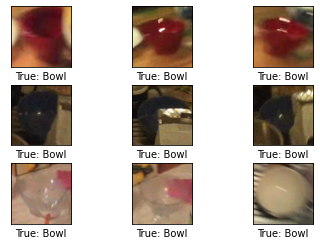

In [23]:
# Load the first images from the train-set.
images = load_images(image_paths=image_paths_train[0:9])

# Get the true classes for those images.
cls_true = cls_train[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, smooth=True)

Le modèle

In [24]:
from sklearn.utils.class_weight import compute_class_weight

In [25]:
class_weight = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(cls_train),
                                    y=cls_train)

class_weight = {i : class_weight[i] for i in range(5)}

In [26]:
model.summary()

Model: "functional_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 conv1_pad (ZeroPadding2D)   (None, 228, 228, 3)       0         
                                                                 
 conv1 (Conv2D)              (None, 113, 113, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 113, 113, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 113, 113, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 113, 113, 32)     288       
                                                      

In [27]:
transfer_layer = model.get_layer('conv_pw_13')

In [28]:
transfer_layer.output

<KerasTensor: shape=(None, 7, 7, 1024) dtype=float32 (created by layer 'conv_pw_13')>

In [29]:
conv_model = Model(inputs=model.input,
                   outputs=transfer_layer.output)

In [30]:
# Start a new Keras Sequential model.
new_model = Sequential()

# Add the convolutional part of the mobile net model from above.
new_model.add(conv_model)

# Flatten the output of the mobile net model because it is from a
# convolutional layer.
new_model.add(Flatten())

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the mobile net model has
# recognized in the image.
new_model.add(Dense(1024, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.5))

# Add the final layer for the actual classification.
new_model.add(Dense(num_classes, activation='softmax'))

In [31]:
loss = 'categorical_crossentropy'
metrics = ['categorical_accuracy']

def print_layer_trainable():
    for layer in conv_model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

On ne train que sur la dernière couche

In [32]:
conv_model.trainable = True

for layer in conv_model.layers:
    # Boolean whether this layer is trainable.
    trainable = ('conv_pw_13' in layer.name)
    
    # Set the layer's bool.
    layer.trainable = trainable

print_layer_trainable()

False:	input_1
False:	conv1_pad
False:	conv1
False:	conv1_bn
False:	conv1_relu
False:	conv_dw_1
False:	conv_dw_1_bn
False:	conv_dw_1_relu
False:	conv_pw_1
False:	conv_pw_1_bn
False:	conv_pw_1_relu
False:	conv_pad_2
False:	conv_dw_2
False:	conv_dw_2_bn
False:	conv_dw_2_relu
False:	conv_pw_2
False:	conv_pw_2_bn
False:	conv_pw_2_relu
False:	conv_dw_3
False:	conv_dw_3_bn
False:	conv_dw_3_relu
False:	conv_pw_3
False:	conv_pw_3_bn
False:	conv_pw_3_relu
False:	conv_pad_4
False:	conv_dw_4
False:	conv_dw_4_bn
False:	conv_dw_4_relu
False:	conv_pw_4
False:	conv_pw_4_bn
False:	conv_pw_4_relu
False:	conv_dw_5
False:	conv_dw_5_bn
False:	conv_dw_5_relu
False:	conv_pw_5
False:	conv_pw_5_bn
False:	conv_pw_5_relu
False:	conv_pad_6
False:	conv_dw_6
False:	conv_dw_6_bn
False:	conv_dw_6_relu
False:	conv_pw_6
False:	conv_pw_6_bn
False:	conv_pw_6_relu
False:	conv_dw_7
False:	conv_dw_7_bn
False:	conv_dw_7_relu
False:	conv_pw_7
False:	conv_pw_7_bn
False:	conv_pw_7_relu
False:	conv_dw_8
False:	conv_dw_8_bn
Fals

In [33]:
optimizer_fine = Adam(lr=1e-7)
new_model.compile(optimizer=optimizer_fine, loss=loss, metrics=metrics)
epochs = 20
#steps_per_epoch = 100

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [36]:
history = new_model.fit(x=generator_train,
                        epochs=epochs,
                        class_weight=class_weight,
                        validation_data=generator_test,
                        validation_steps=steps_test)

Epoch 1/20
8/8 [==============================] - 351s 50s/step - loss: 3.4801 - categorical_accuracy: 0.1404 - val_loss: 2.7119 - val_categorical_accuracy: 0.2267
Epoch 2/20
8/8 [==============================] - 26s 4s/step - loss: 3.4825 - categorical_accuracy: 0.2456 - val_loss: 2.5433 - val_categorical_accuracy: 0.2211
Epoch 3/20
8/8 [==============================] - 26s 4s/step - loss: 3.7487 - categorical_accuracy: 0.2105 - val_loss: 2.3971 - val_categorical_accuracy: 0.2122
Epoch 4/20
8/8 [==============================] - 26s 4s/step - loss: 2.9669 - categorical_accuracy: 0.2807 - val_loss: 2.2792 - val_categorical_accuracy: 0.2119
Epoch 5/20
8/8 [==============================] - 26s 4s/step - loss: 3.2644 - categorical_accuracy: 0.1754 - val_loss: 2.1804 - val_categorical_accuracy: 0.2133
Epoch 6/20
8/8 [==============================] - 26s 4s/step - loss: 2.8469 - categorical_accuracy: 0.2105 - val_loss: 2.1142 - val_categorical_accuracy: 0.2105
Epoch 7/20
8/8 [==========

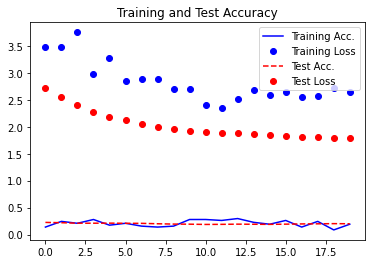

In [37]:
plot_training_history(history)

In [38]:
result = new_model.evaluate(generator_test, steps=steps_test)

446/446 [==============================] - 27s 61ms/step - loss: 1.7819 - categorical_accuracy: 0.2015


In [39]:
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

Test-set classification accuracy: 20.15%
